In [11]:
#CNN Model
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# !pip uninstall torch_xla
# !pip3 install https://storage.googleapis.com/tpu-pytorch/wheels/tpuvm/torch_xla-1.10-cp38-cp38-linux_x86_64.whl
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import time
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
#References from documentation
start = time.time()
trans = torchvision.transforms.Compose([
    torchvision.transforms.RandAugment(),
    torchvision.transforms.AutoAugment(),
#     torchvision.transforms.RandomHorizontalFlip(p=0.5)
#     torchvision.transforms.RandomEqualize(p=0.5),
    torchvision.transforms.RandomVerticalFlip(p=0.5),
#     torchvision.transforms.RandomInvert(p=0.5),
    torchvision.transforms.Resize(size =(300,300)),
    ToTensor()
])
batchS = 100
data = torchvision.datasets.ImageFolder('/kaggle/input/wild-animals/Wild_animals_512',transform = trans)
train_data,test_data = torch.utils.data.random_split(data,[round(data.__len__()*0.6),round(data.__len__()*0.4)])

#valid_data,testy_data = torch.utils.data.random_split(test_data,[round(test_data.__len__()*0.5),round(test_data.__len__()*0.5)])
valid_data,testy_data = torch.utils.data.random_split(test_data,[345,344])
train_load = DataLoader(train_data,shuffle = True,batch_size= batchS,drop_last=True)
valid_load = DataLoader(valid_data,shuffle = True,batch_size= batchS,drop_last = True)
test_load = DataLoader(testy_data,shuffle = True,batch_size= batchS,drop_last = True)
print(len(data))

print('done')
print(data.class_to_idx)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1723
done
{'cheetah-resize-512': 0, 'fox-resize-512': 1, 'hyena-resize-512': 2, 'lion-resize-512': 3, 'tiger-resize-512': 4, 'wolf-resize-512': 5}


In [ ]:
#Neural Network referenced from  https://pytorch.org/tutorials/beginner/examples_nn/polynomial_module.html
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

#Initial Model code referenced from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
#Code from the 'Define the Network' section
#Experiment 1
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        #Feature extraction
        self.conv= nn.Conv2d(3,64,9)
        self.conv2 = nn.Conv2d(64,128,5)
        self.conv3 = nn.Conv2d(128,256,5)
        self.conv4 = nn.Conv2d(256,512,5)
        self.conv5 = nn.Conv2d(512,1024,5)
        self.bat2d1 = nn.BatchNorm2d(64)
        self.bat2d2 = nn.BatchNorm2d(128)
        self.bat2d3 = nn.BatchNorm2d(256)
        self.bat2d4 = nn.BatchNorm2d(512)
        self.bat2d5 = nn.BatchNorm2d(1024)
        self.bat1d = nn.BatchNorm1d(196)
        self.bat1d2 = nn.BatchNorm1d(256)
#         self.bat1d3 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(p= 0.8)
        self.dropout2 = nn.Dropout(p=0.5)

        
        #Classification layer
        self.lin = nn.Linear(1024*5*5,196)
        self.lin3 = nn.Linear(196,256)
#         self.lin4 = nn.Linear(256,512)
        self.lin2 = nn.Linear(256,6)
        
    def forward(self,x):
        #First two lines are referenced
        x = F.max_pool2d(F.relu(self.conv(x)),(2,2))
        x=self.bat2d1(x)
        self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x=self.bat2d2(x)
        self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
        x=self.bat2d3(x)
        self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv4(x)),(2,2))
        x=self.bat2d4(x)
        self.dropout(x)
        x = F.max_pool2d(F.relu(self.conv5(x)),(2,2))
        x=self.bat2d5(x)
        self.dropout(x)
#         print(x.shape)
        #Flattening tensors
        x = torch.flatten(x,1)
#         print(x.shape)
        x = F.relu(self.lin(x))
        self.bat1d(x)
        x= F.relu(self.lin3(x))
        self.bat1d2(x)
        self.dropout2(x)
#         x= F.relu(self.lin4(x))
#         self.bat1d3(x)
#         self.dropout2(x)
        x = F.softmax(self.lin2(x),dim = 1)
        return x
    
model = Model()
device = torch.device("cuda:0")
# model.to(torch.device("cuda:0"))
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
  # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

model.to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01,weight_decay=0.0000000001)
lossfn = nn.CrossEntropyLoss()
lossx = 0
lossxt = 0
l1 = 0

#count = []
lossgraph = []
testgraph = []
#Code referenced from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#I extracted data from the DataLoaders following the tutorial above
#I used two for loops and called the optimizer and loss functions in a similar way
#From the 'Define the network' section of the webpage.
for epoch in range(550):
    print(epoch)
    
    for i,data in enumerate(train_load, 0):
        lossx = 0
        pics, label = data
        pics, label = pics.cuda(), label.cuda()
#         pics,label = pics.to(device),label.to(device)
        
        #print(pics.shape)
        optimizer.zero_grad()
        output = model(pics)
        #reshaping label
        #label = torch.tensor(label)
        labely = torch.zeros(batchS,6)
        for j in range(batchS):
            labely[j][label[j]] = 1
        #print(output)
        labely = labely.cuda()
#         labely = labely.to(device)
#         https://stackoverflow.com/questions/58172188/how-to-add-l1-regularization-to-pytorch-nn-model
       
#         for param in model.parameters():
#             l1 += param.abs().sum()
        loss = lossfn(output,labely) 
        #lossgraph.append(loss)
        loss.backward()
        lossx += loss
        #print(output)
        optimizer.step()
        #graphing loss
        
        #print(len(lossgraph),epoch,i)
    lossgraph.append(lossx.item())

    testingloss = nn.CrossEntropyLoss()
#     classes = {0:'Motorbikes',1:'Airplanes',2:'Schooner'}
    total = 0
    correct = 0
    for i, data in enumerate(valid_load,0):
        lossxt = 0
        pics,label = data
        pics, label = pics.cuda(), label.cuda()
#         pics,label = pics.to(device),label.to(device)
        #print(pics.shape)
        output = model(pics)
        labely = torch.zeros(batchS,6)
        for j in range(batchS):
            labely[j][label[j]] = 1
            #print(output)
        labely = labely.cuda()
#         labely = labely.to(device)
        loss = testingloss(output,labely)
        lossxt += loss.item()
        #print(output)
        maxele,maxindx = torch.max(output,1)
        for j in range(batchS):
#             print('Prediction: {0}, Answer: {1}'.format(classes[maxindx[j].item()],classes[label[j].item()]))
            #print(maxindx[j].item(),label[j].item())
            if(torch.eq(maxindx[j],label[j])):
                correct = correct +1
            total = total+1
    #print(correct,total)
    
    #plt.legend('Training set','Validation set')
    accuracy = (correct/total)*100
    #print('Accuracy is {0:.2f}%'.format(accuracy))
    testgraph.append(lossxt)

        #plt.ylim(4e-1,7e-1)
#plt.yscale('log')
#plt.figure(figsize = (1,1))
#print(testgraph)

#plt.yscale('log')
PATH = '/kaggle/working/state_dict_model.pt'
torch.save(model.state_dict(), PATH)



torch.cuda.empty_cache()
        
        
    



    
#for epoch,data in enumerate(train_load,0):
    #inputy, label= data
    #forward(inputy)
#ask how to get gradient of linear stuff and how to determine convolutions

In [ ]:
plt.yscale('log')
plt.plot(testgraph,'r-')
plt.plot(lossgraph)

In [ ]:
#validation cell
#Code referenced from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#I extracted data from the DataLoaders following the tutorial above
#I used two for loops and called the optimizer and loss functions in a similar way
#From the 'Define the network' section of the webpage.
'''

'''
#testgraph = []
#testingloss = nn.CrossEntropyLoss()
total = 0
correct = 0
cl = []
pl = []
for i, data in enumerate(valid_load,0):
    lossxt = 0
    pics,label = data
    pics, label = pics.cuda(), label.cuda()
#     pics,label = pics.to(device),label.to(device)
    #print(pics.shape)
    output = model(pics)
    labely = torch.zeros(batchS,6)
    for j in range(batchS):
        labely[j][label[j]] = 1
        #print(output)
    labely = labely.cuda()
    #loss = testingloss(output,labely)
    #lossxt += loss.item()
    #print(output)
    maxele,maxindx = torch.max(output,1)
    #testgraph.append(lossxt)
    for j in range(batchS):
#         print('Prediction: {0}, Answer: {1}'.format(classes[maxindx[j].item()],classes[label[j].item()]))
        print(maxindx[j].item(),label[j].item())
        cl.append(label[j].item())
        pl.append(maxindx[j].item())
        if(torch.eq(maxindx[j],label[j])):
            correct = correct +1
            print('Yay')
        total = total+1
print(correct,total)
#plt.plot(testgraph)
#plt.legend('Training set','Validation set')
accuracy = (correct/total)*100
fscore = f1_score(cl,pl,average='macro')
print("F1 score is {0:.2f}".format(fscore))
print('Accuracy is {0:.2f}%'.format(accuracy))
stop = time.time()
print(f'time is {stop-start}')
    

In [ ]:
#Testing data
#Code referenced from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#I extracted data from the DataLoaders following the tutorial above
#I used two for loops and called the optimizer and loss functions in a similar way.
#From the 'Define the network' section of the webpage.
total = 0
correct =0
cl2 = []
pl2 = []
for i2, data2 in enumerate(test_load,0):
    #lossxt = 0
    pics,label = data2
    pics, label = pics.cuda(), label.cuda()
#     pics,label = pics.to(device),label.to(device)
    #print(pics.shape)
    output = model(pics)
    labely = torch.zeros(batchS,6)
    for j in range(batchS):
        labely[j][label[j]] = 1
        #print(output)
#     labely = labely.cuda()
#     loss = testingloss(output,labely)
    #lossxt += loss
    #print(output)
    maxele,maxindx = torch.max(output,1)
    #testgraph.append(lossxt)
    for j in range(batchS):
        #print('Prediction: {0}, Answer: {1}'.format(classes[maxindx[j].item()],classes[label[j].item()]))
        #print(maxindx[j].item(),label[j].item())
        cl2.append(label[j].item())
        pl2.append(maxindx[j].item())
        if(torch.eq(maxindx[j],label[j])):
            correct = correct +1
        total = total+1
print(correct,total)
#plt.plot(testgraph)
accuracy = (correct/total)*100
fscore = f1_score(cl2,pl2,average='macro')
print("F1 score is {0:.2f}".format(fscore))
print('Accuracy is {0:.2f}%'.format(accuracy))


# KNN model
I am utilizing the knn method of classification on these images by first putting on the images and their labels into seperate list. I will then put these list into sklearn's knn function.

In [6]:
#https://medium.com/swlh/image-classification-with-k-nearest-neighbours-51b3a289280
'''
PCA takes too long
individual histograms using numpy is 24%
histograms using cv2 library: >20 %
'''
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from skimage.io import imread
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import cv2
import time
import skimage.io
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
trans = torchvision.transforms.Compose([
    torchvision.transforms.RandAugment(),
    torchvision.transforms.Resize(size =(32,32)),
    ToTensor()
])
start = time.time()
il = np.empty((1723,1))
il = []
labe = [] 
validlabe = []
testlabs = []
index = np.random.choice(1723,1723)
print(len(index))
#[1]:https://pyimagesearch.com/2016/08/08/k-nn-classifier-for-image-classification/
#The function is reference from the article above
def extract_color_histogram(image,bins=(8,8,8)):
    hsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2],None,bins,[0,180,0,256,0,256])
    cv2.normalize(hist,hist)
    return hist.flatten()
# [2]I used 'https://medium.com/swlh/image-classification-with-k-nearest-neighbours-51b3a289280' method of 
#listing directories of pre-processing images. I used the blog's method of listing directories to
# get the image and labels
p = Path('../input/wild-animals/Wild_animals_512')
parameters = {'n_neighbors':[100,500], 'weights':('uniform','distance'),'leaf_size':[30,100],'p':(1,2)}
folders = [d for d in p.iterdir() if d.is_dir()]
classes = [d.name for d in folders]
counter =0
for i,direc in enumerate(folders):
    for file in direc.iterdir():
        img = cv2.imread(str(file))
        cv2.resize(img,(32,32))
        tot =  extract_color_histogram(img)

        il.append(tot)
        labe.append(str(direc))
#     print(il)
# normalize(il)
# print(np.shape(il))
itest = []
ilabel = []
for i in range(1723):
    itest.append(il[index[i]])
    ilabel.append(labe[index[i]])
        
data2 = torchvision.datasets.ImageFolder('../input/wild-animals/Wild_animals_512',transform = trans)
train_data2,test_data2 = torch.utils.data.random_split(data2,[round(data2.__len__()*0.6),round(data2.__len__()*0.4)])
valid_data2,testy_data2 = torch.utils.data.random_split(test_data2,[345,344])
images  = []
labs = []
validImages = []
validlabs = []
featureExtractor = nn.Sequential(

        nn.Conv2d(3,64,9),
        nn.ReLU()
)
#featureExtractor.to(torch.device('cuda:0'))
for i in range(len(train_data2)):
    pics, label = train_data2[i]
#     pics = pics.cuda()
#     pics = featureExtractor(pics)
#     images.append(pics.flatten().numpy())
    labs.append(label)
    
# print(len(valid_data2))
for j in range(len(valid_data2)):
    pics,label = valid_data2[j]
#     pics = pics.cuda()
#     pics = featureExtractor(pics)
#     validImages.append(pics.flatten().numpy())
    validlabs.append(label)

print('Doing knn now')
print(len(il))
correct = 0
total = 0
modelKnn = KNeighborsClassifier(n_neighbors = 200)
grid = GridSearchCV(modelKnn,parameters)
print(np.shape(itest[:1034]),np.shape(np.array(ilabel)),np.shape(itest[1035:1380]))

modelKnn.fit(itest[:1034],ilabel[:1034])
print(len(itest[:1034]))
for i in range(len(validlabs)):
    pred = modelKnn.predict(itest[1035+i].reshape(1,-1))
    if pred == ilabel[1035+i]:
#         print('Yay')
        correct+=1
    total += 1
#     print(f'Actual is {ilabel[1035+i]} and predicted is {pred}')
accuracy = (correct/total)*100
stop = time.time()
print(f'Training time is {stop-start}')
print(accuracy)
correct = 0
total = 0
# accuracy = (correct/total)*100
c = []
pre = []
for i in range(len(itest[1380:])):
    pred = modelKnn.predict(itest[1380+i].reshape(1,-1))
    pre.append(pred)
    c.append(ilabel[1380+i])
    if pred == ilabel[1380+i]:
#         print('Yay')
        correct+=1
    total += 1
#     print(f'Actual is {ilabel[1035+i]} and predicted is {pred}')
accuracy = (correct/total)*100
stop = time.time()
print(f'Training time is {stop-start}')
print('test accuracy is ',accuracy)
print('f1 score is ',f1_score(c,pre,average='macro'))



    

1723


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Doing knn now
1723
(1034, 512) (1723,) (345, 512)
1034
Training time is 53.09102487564087
36.52173913043478
Training time is 53.72905683517456
test accuracy is  35.8600583090379
f1 score is  0.33131496633710356


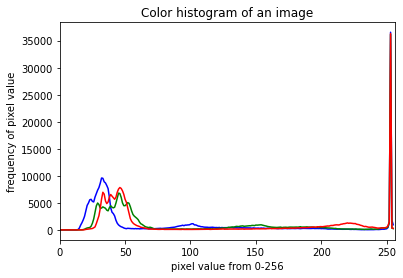

In [4]:
#Cell for visualizing a color histogram
#[3]https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('../input/wild-animals/Wild_animals_512/fox-resize-512/00000001_512resized.png')
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
    plt.title('Color histogram of an image')
    plt.xlabel('pixel value from 0-256')
    plt.ylabel('frequency of pixel value')

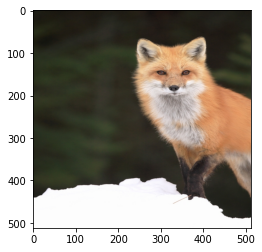

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread('../input/wild-animals/Wild_animals_512/fox-resize-512/00000001_512resized.png')
imageplot = plt.imshow(image)
plt.show()

# Decision Tree Classifier

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0.21159420289855072
21.15942028985507
test accuracy 24.12790697674419
reached
f1 score:  0.23549349559724184
Training time is 33.351738691329956


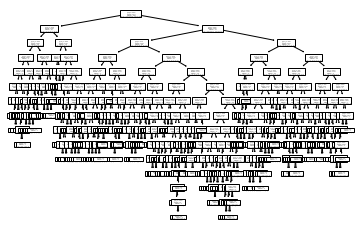

In [12]:
%matplotlib inline
'''
RandomForest = 35%
DecisionTree = 24% with visualization
'''
#22% for raw pixels
# 30 % after convolutions
# Adapted from https://scikit-learn.org/stable/modules/tree.html#tree
from sklearn.datasets import load_iris
from sklearn import tree
import time
import graphviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from matplotlib.pyplot import imshow
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
parameters = {'criterion':('gini','entropy'), 'splitter':('best','random')}
startT = time.time()
images = []
validImages = []
testImages=[]
testlabs = []
classes = []
labs = []
validlabs = []
featureExtractor = nn.Sequential(

        nn.Conv2d(3,64,9),
        nn.ReLU(),
#         nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Conv2d(64,128,3),
        nn.ReLU(),
#         nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Conv2d(128,256,3),
        nn.ReLU(),
#         nn.BatchNorm2d(),
        nn.MaxPool2d(2)
        
)
path = '../input/wild-animals/Wild_animals_512'
trans = torchvision.transforms.Compose([
    torchvision.transforms.RandAugment(),
    torchvision.transforms.Resize(size =(32,32)),
    ToTensor()
])
data2 = torchvision.datasets.ImageFolder('../input/wild-animals/Wild_animals_512',transform = trans)
train_data2,test_data2 = torch.utils.data.random_split(data2,[round(data2.__len__()*0.6),round(data2.__len__()*0.4)])
valid_data2,testy_data2 = torch.utils.data.random_split(test_data2,[345,344])
for i in range(len(train_data2)):
    pics, label = train_data2[i]
    images.append(featureExtractor(pics).detach().flatten().numpy())
    labs.append(label)
    
    
# print(len(valid_data2))
for j in range(len(valid_data2)):
    pics,label = valid_data2[j]
    validImages.append(featureExtractor(pics).detach().flatten().numpy())
    validlabs.append(label)
for j in range(len(testy_data2)):
    pics,label = testy_data2[j]
    testImages.append(featureExtractor(pics).detach().flatten().numpy())
    testlabs.append(label)

clf = DecisionTreeClassifier(criterion='entropy')
grid = GridSearchCV(clf,parameters)
clf.fit(images,labs)
stopT = time.time()
tree.plot_tree(clf)
print(clf.score(validImages,validlabs))
correct = 0
total = 0
for i in range(len(validlabs)):
    pred = clf.predict(np.array(validImages[i]).reshape(1,-1))
    if pred == validlabs[i]:
        correct +=1
    total += 1
#     print('Actual: {0}, Predicted: {1}'.format(validlabs[i],pred))
accuracy = (correct/total)*100
print(accuracy)
correct = 0
total = 0
c = []
pre = []
for i in range(len(testlabs)):
    pred = clf.predict(np.array(testImages[i]).reshape(1,-1))
    pre.append(pred)
    c.append(testlabs[i])
    if pred == testlabs[i]:
        correct +=1
    total += 1
#     print('Actual: {0}, Predicted: {1}'.format(testlabs[i],pred))
accuracy = (correct/total)*100
print('test accuracy',accuracy)
print('reached')
print('f1 score: ',f1_score(c,pre,average = 'macro'))
print(f'Training time is {stopT-startT}')
    

# Naive-Bayes Classifier

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from matplotlib.pyplot import imshow
import numpy as np
import time
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
startT = time.time()
featureExtractor = nn.Sequential(

        nn.Conv2d(3,64,9),
        nn.ReLU(),
#         nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Conv2d(64,256,3),
        nn.ReLU(),
#         nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Conv2d(256,1024,3),
        nn.ReLU(),
#         nn.BatchNorm2d(),
        nn.MaxPool2d(2)
        
        
)
trans = torchvision.transforms.Compose([
    torchvision.transforms.RandAugment(),
    torchvision.transforms.Resize(size =(32,32)),
    ToTensor()
])
data2 = torchvision.datasets.ImageFolder('../input/wild-animals/Wild_animals_512',transform = trans)
train_data2,test_data2 = torch.utils.data.random_split(data2,[round(data2.__len__()*0.6),round(data2.__len__()*0.4)])
valid_data2,testy_data2 = torch.utils.data.random_split(test_data2,[345,344])
labs = []
images = []
validImages = []
validlabs = []
testImages = []
testlabs = []

for i in range(len(train_data2)):
    pics, label = train_data2[i]
    images.append(featureExtractor(pics).detach().flatten().numpy())
    labs.append(label)
    
# print(len(valid_data2))
for j in range(len(valid_data2)):
    pics,label = valid_data2[j]
    validImages.append(featureExtractor(pics).detach().flatten().numpy())
    validlabs.append(label)
for j in range(len(testy_data2)):
    pics,label = testy_data2[j]
    testImages.append(featureExtractor(pics).detach().flatten().numpy())
    testlabs.append(label)
nbModel = GaussianNB()
nbModel.fit(images,labs)
stopT = time.time()
print(nbModel.score(validImages,validlabs))
correct = 0
total = 0
for i in range(len(validlabs)):
    pred = nbModel.predict(np.array(validImages[i]).reshape(1,-1))
    if pred == validlabs[i]:
#         print('Yippee ka yay!')
        correct +=1
    total += 1
#     print('Actual: {0}, Predicted: {1}'.format(validlabs[i],pred))
accuracy = (correct/total)*100
print(accuracy)
correct = 0
total = 0
c= []
pre = []
for i in range(len(testlabs)):
    pred = nbModel.predict(np.array(testImages[i]).reshape(1,-1))
    pre.append(pred)
    c.append(testlabs[i])
    if pred == testlabs[i]:
#         print('Yippee ka yay!')
        correct +=1
    total += 1
#     print('Actual: {0}, Predicted: {1}'.format(validlabs[i],pred))
accuracy = (correct/total)*100
print(accuracy)
print('f1 score:', f1_score(c,pre,average = 'macro'))
print(f'Training time is {stopT-startT}')




/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


0.2144927536231884
21.44927536231884
25.290697674418606
f1 score: 0.16440343736127097
Training time is 34.180763483047485


# Support Vector Classifier

In [33]:
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torchvision
import torch.nn as nn
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

start = time.time()
trans = torchvision.transforms.Compose([
    torchvision.transforms.RandAugment(),
    torchvision.transforms.Resize(size =(32,32)),
    ToTensor()
])

data2 = torchvision.datasets.ImageFolder('../input/wild-animals/Wild_animals_512',transform = trans)
train_data2,test_data2 = torch.utils.data.random_split(data2,[round(data2.__len__()*0.6),round(data2.__len__()*0.4)])
valid_data2,testy_data2 = torch.utils.data.random_split(test_data2,[345,344])

labs = []
images = []
validImages = []
validlabs = []
testImages = []
testlabs = []

featureExtractor = nn.Sequential(

        nn.Conv2d(3,64,9),
        nn.ReLU(),
#         nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
        nn.Conv2d(64,256,3),
        nn.ReLU(),
#         nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
        nn.Conv2d(256,1024,3),
        nn.ReLU(),
#         nn.BatchNorm2d(),
        nn.MaxPool2d(2)
        
)

for i in range(len(train_data2)):
    pics, label = train_data2[i]
    images.append(featureExtractor(pics).detach().flatten().numpy())
    labs.append(label)
    
# print(len(valid_data2))
for j in range(len(valid_data2)):
    pics,label = valid_data2[j]
    validImages.append(featureExtractor(pics).detach().flatten().numpy())
    validlabs.append(label)
    
for j in range(len(testy_data2)):
    pics,label = testy_data2[j]
    testImages.append(featureExtractor(pics).detach().flatten().numpy())
    testlabs.append(label)
svcModel = SVC(C = 1000000,kernel = 'rbf',degree = 3,gamma= 'auto')
parameters = {'C':[10E-5,10E5],'kernel':['poly','rbf','sigmoid'],'degree':[3,5],'gamma':['scale','auto']}
grid = GridSearchCV(svcModel,parameters)
svcModel.fit(images,labs)
print(svcModel.score(validImages,validlabs)*100)
correct = 0
total = 0
for i in range(len(validlabs)):
    pred = svcModel.predict(np.array(validImages[i]).reshape(1,-1))
    if pred == validlabs[i]:
#         print('Yippee ka yay!')
        correct +=1
    total += 1
#     print('Actual: {0}, Predicted: {1}'.format(validlabs[i],pred))
accuracy = (correct/total)*100
stop = time.time()
print(accuracy)
# print(grid.best_params_)
print(f'Training time is {stop-start} seconds')
correct = 0
total = 0
c = []
pre = []
for i in range(len(testlabs)):
    pred = svcModel.predict(np.array(testImages[i]).reshape(1,-1))
    pre.append(pred)
    c.append(testlabs[i])
    if pred == testlabs[i]:
#         print('Yippee ka yay!')
        correct +=1
    total += 1
#     print('Actual: {0}, Predicted: {1}'.format(validlabs[i],pred))
accuracy = (correct/total)*100
print(accuracy)
print('f1 score:', f1_score(c,pre,average = 'macro'))


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


34.78260869565217
34.78260869565217
Training time is 37.82555866241455 seconds
25.581395348837212
f1 score: 0.2506235348133744


Text(0.5, 0, 'Classifiers')

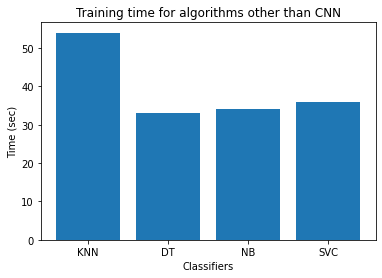

In [7]:
#plotting cell
%matplotlib inline
import matplotlib.pyplot as plt
timex = [ 'KNN', 'DT','NB','SVC']
timey = [54,33,34,36]
plt.bar(timex,timey)
plt.title('Training time for algorithms other than CNN')
plt.ylabel('Time (sec)')
plt.xlabel('Classifiers')
#CNN took >19000 seconds

Text(0.5, 0, 'Classifiers')

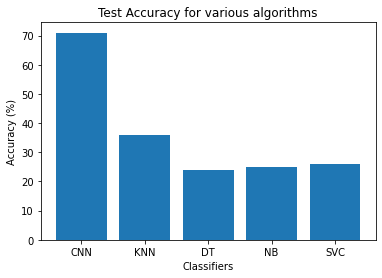

In [8]:
#plotting cell
%matplotlib inline
import matplotlib.pyplot as plt
acx = ['CNN', 'KNN', 'DT','NB','SVC']
acy = [71,36,24,25,26]
plt.bar(acx,acy)
plt.title('Test Accuracy for various algorithms')
plt.ylabel('Accuracy (%)')
plt.xlabel('Classifiers')

Text(0.5, 0, 'Classifiers')

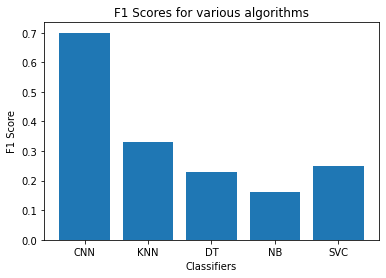

In [9]:
#plotting cell
%matplotlib inline
import matplotlib.pyplot as plt
fx = ['CNN', 'KNN', 'DT','NB','SVC']
fy = [0.70,0.33,0.23,0.16,0.25]
plt.bar(fx,fy)
plt.title('F1 Scores for various algorithms')
plt.ylabel('F1 Score')
plt.xlabel('Classifiers')